# Setup

In [1]:
# @title Install dependencies
# !pip install opencv-python 
# !pip install numba 
# !pip install tifffile 

# !pip install elasticdeform

In [2]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests

import elasticdeform

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data loading

In [4]:
# @title Download and normalize data
filenames = ["cells_train.npz",
             "cells_test.npz"]
urls = ["https://osf.io/z3h78/download",
        "https://osf.io/ft5p3/download"]
expected_md5s = ["85e1fe2ee8d936c1083d62563d79d958",
                 "e8f789abe20a7efde806d9ba03d20fd7"]

for fname, url, expected_md5 in zip(filenames, urls, expected_md5s):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      elif hashlib.md5(r.content).hexdigest() != expected_md5:
        print("!!! Data download appears corrupted !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)

cells_train = np.load('cells_train.npz', allow_pickle=True)['arr_0'].item()
cells_test = np.load('cells_test.npz', allow_pickle=True)['arr_0'].item()
imgs_train = np.array(cells_train['imgs']).transpose(0, 3, 1, 2)
masks_train = np.array(cells_train['masks'])
imgs_test = np.array(cells_test['imgs']).transpose(0, 3, 1, 2)
masks_test = np.array(cells_test['masks'])

# we are going to normalize the images so their pixel values mostly fall between 0 and 1
# this is helpful if you have images on a variety of scales
# we will also return the images as float32 <- the data type that is fast for GPU computation
def normalize99(img):
  """ normalize image so 0.0 is 1st percentile and 1.0 is 99th percentile """
  X = img.copy()
  x01 = np.percentile(X, 1)
  x99 = np.percentile(X, 99)
  X = (X - x01) / (x99 - x01)
  return X.astype(np.float32)


imgs_train = np.array([normalize99(img) for img in imgs_train])
imgs_test = np.array([normalize99(img) for img in imgs_test])

Plot a random training image and its masks. 

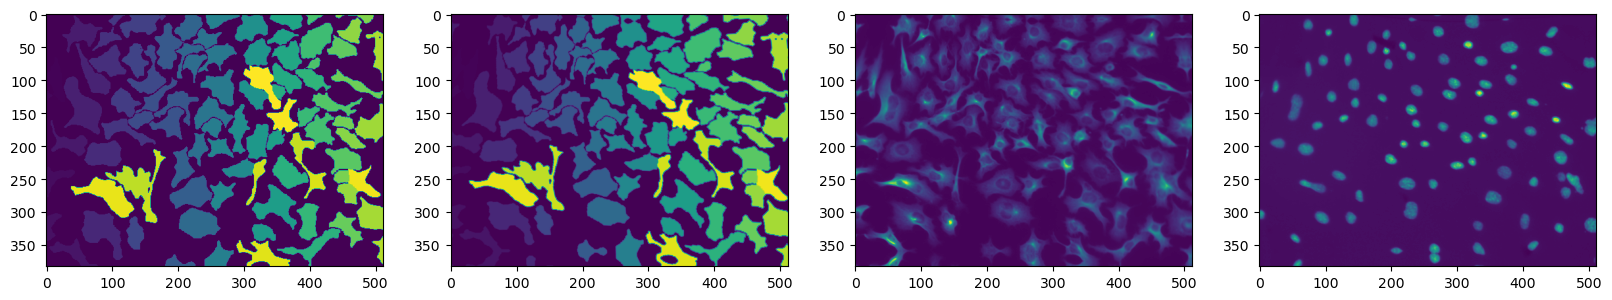

In [5]:
el0, el1, el2 = elasticdeform.deform_random_grid([masks_train[0], imgs_train[0][0], imgs_train[0][1]], sigma=25, points=3, mode='mirror', prefilter=False)
plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(masks_train[0])
plt.subplot(1, 4, 2)
plt.imshow(el0)
plt.subplot(1, 4, 3)
plt.imshow(el1)
plt.subplot(1, 4, 4)
plt.imshow(el2)

there are 30 cells in this image


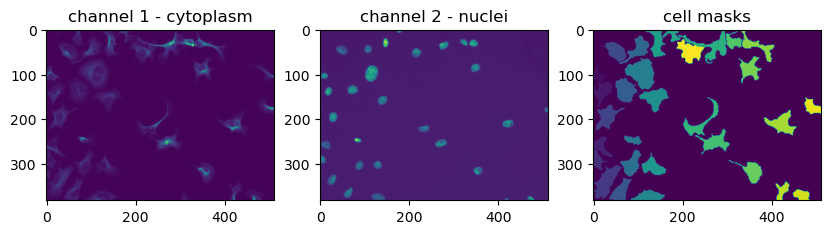

In [6]:
irand = np.random.randint(len(imgs_train))

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(imgs_train[irand][0])
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 3, 2)
plt.imshow(imgs_train[irand][1])
plt.title('channel 2 - nuclei')

plt.subplot(1, 3, 3)
plt.imshow(masks_train[irand])
plt.title('cell masks')
print(f'there are {masks_train[irand].max()} cells in this image')
plt.show()

# Creating Weighted Map

In [9]:
def weighted_map_cell_not_cell(img, k_size=10, blur_size=11, border_size=4, border_scale=2):

  kernel = np.ones((k_size, k_size), 'uint8')
  kernel_2 = np.ones((border_size, border_size), 'uint8')
  w_map = np.zeros_like(img).astype(float) #weighted map around each image
  mask = np.zeros_like(img).astype(float)      #mask to select weighted map in close boundaries
  cell = np.zeros_like(img).astype(float)   #mask to remove weighted map remained within cells
  merge = np.zeros_like(img).astype(float)   #to create borders for merged cells 

  for l in np.unique(img)[1:] :
    label = np.array(img == l).astype(float)
    dilate = cv2.dilate(label, kernel, iterations=1)   #to find close bounderies and create the mask
    blur = cv2.GaussianBlur(label,(blur_size,blur_size),blur_size)
    border = cv2.bitwise_xor(blur,label)

    w_map += border
    mask += dilate - label
    cell += label

    label_1 = np.array(img == l).astype(float)
    dilate_1 = cv2.dilate(label_1, kernel_2, iterations=1)
    for i in np.unique(img)[1:] :
      if i != l :
        label_2 = np.array(img == i).astype(float)
        dilate_2 = cv2.dilate(label_2, kernel_2, iterations=1)
        merge_border = cv2.bitwise_and(dilate_1, dilate_2)
        merge += merge_border
  
  merge = np.array(merge>0).astype(float)*border_scale
      

  cell = np.array(cell > 0).astype('uint8')    #label cells to 1   
  mask = np.array(mask > 1).astype('uint8')
  not_cell = (cv2.bitwise_not(cell)/255).astype('uint8') #bitwise_not returns between 0,255
  map = cv2.bitwise_and(w_map, w_map, mask=mask)
  weighted = cv2.bitwise_and(map, map, mask=not_cell)    #remove weighted map within cells
  weighted += merge
  return weighted, cell, merge

In [10]:
weighted_map_train =  np.load("weighted_map_train.npy")
cell_labels_train = np.load("cell_labels_train.npy")
not_cell_labels_train = np.load("not_cell_labels_train.npy")
merged_borders_train = np.load("merged_borders_train.npy")

weighted_map_test =  np.load("weighted_map_test.npy")
cell_labels_test = np.load("cell_labels_test.npy")
not_cell_labels_test = np.load("not_cell_labels_test.npy")
merged_borders_test = np.load("merged_borders_test.npy")

In [11]:
# cell_labels_train = np.zeros_like(masks_train).astype(float)
# weighted_map_train = np.zeros_like(masks_train).astype(float)
# merged_borders_train = np.zeros_like(masks_train).astype(float)
# for i, img in enumerate(masks_train):
#   weighted, cell, borders =  weighted_map_cell_not_cell(img)
#   cell_labels_train[i] = cell
#   weighted_map_train[i] = weighted
#   merged_borders_train[i] = borders

# cell_labels_train = cell_labels_train - merged_borders_train/3
# cell_labels_train = np.where(cell_labels_train < 0, 0, cell_labels_train)
# not_cell_labels_train = (cell_labels_train-1)*-1


# cell_labels_test = np.zeros_like(masks_test).astype(float)
# weighted_map_test = np.zeros_like(masks_test).astype(float)
# merged_borders_test = np.zeros_like(masks_test).astype(float)
# for i, img in enumerate(masks_test):
#   weighted, cell, borders =  weighted_map_cell_not_cell(img)
#   cell_labels_test[i] = cell
#   weighted_map_test[i] = weighted
#   merged_borders_test[i] = borders

# cell_labels_test = cell_labels_test - merged_borders_test/3
# cell_labels_test = np.where(cell_labels_test < 0, 0, cell_labels_test)
# not_cell_labels_test = (cell_labels_test-1)*-1

In [12]:
# np.save("weighted_map_train.npy", weighted_map_train)
# np.save("cell_labels_train.npy", cell_labels_train)
# np.save("not_cell_labels_train.npy", not_cell_labels_train)
# np.save("merged_borders_train.npy", merged_borders_train)

# np.save("weighted_map_test.npy", weighted_map_test)
# np.save("cell_labels_test.npy", cell_labels_test)
# np.save("not_cell_labels_test.npy", not_cell_labels_test)
# np.save("merged_borders_test.npy", merged_borders_test)

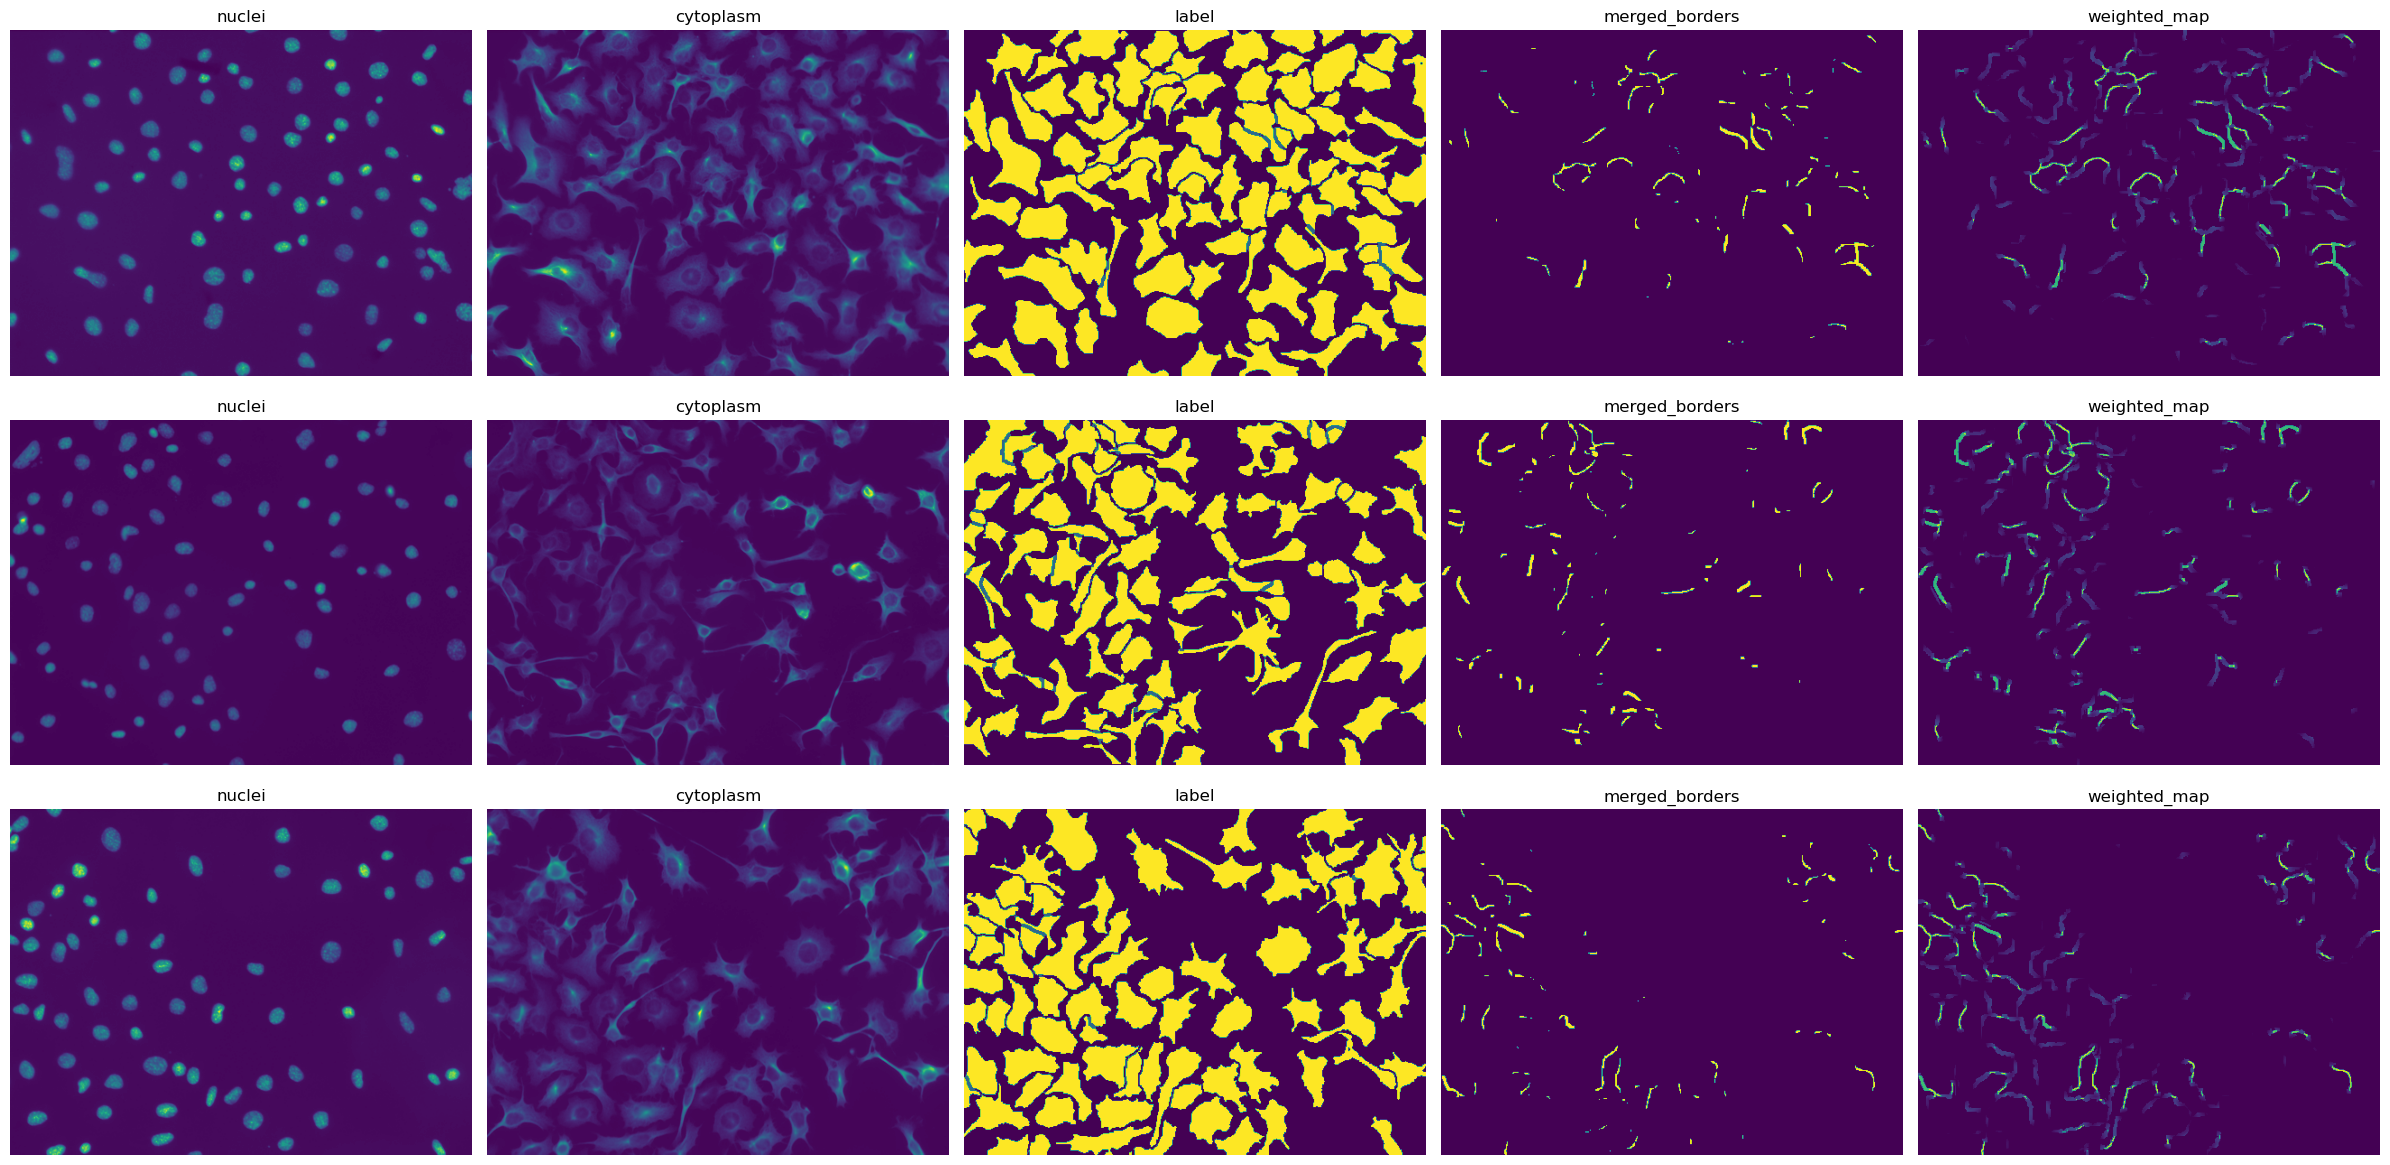

In [13]:
plt.figure(figsize=(24, 12))
for j in range(3):
  plt.subplot(3, 5, 5*j + 1)
  plt.imshow(imgs_train[j][1])
  plt.title('nuclei')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 2)
  plt.imshow(imgs_train[j][0])
  plt.title('cytoplasm')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 3)
  plt.imshow(cell_labels_train[j])
  plt.title('label')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 4)
  plt.imshow(merged_borders_train[j])
  plt.title('merged_borders')
  plt.axis('off')

  plt.subplot(3, 5, 5*j + 5)
  plt.imshow(weighted_map_train[j])
  plt.title('weighted_map')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
w_labels_train = np.stack((weighted_map_train, cell_labels_train), axis=1)
w_labels_test = np.stack((weighted_map_test, cell_labels_test), axis=1)
w_labels_train.shape , w_labels_test.shape 

((81, 2, 383, 512), (10, 2, 383, 512))

## Create transform function for augmentations

adapted from [cellpose/transforms.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/transforms.py).

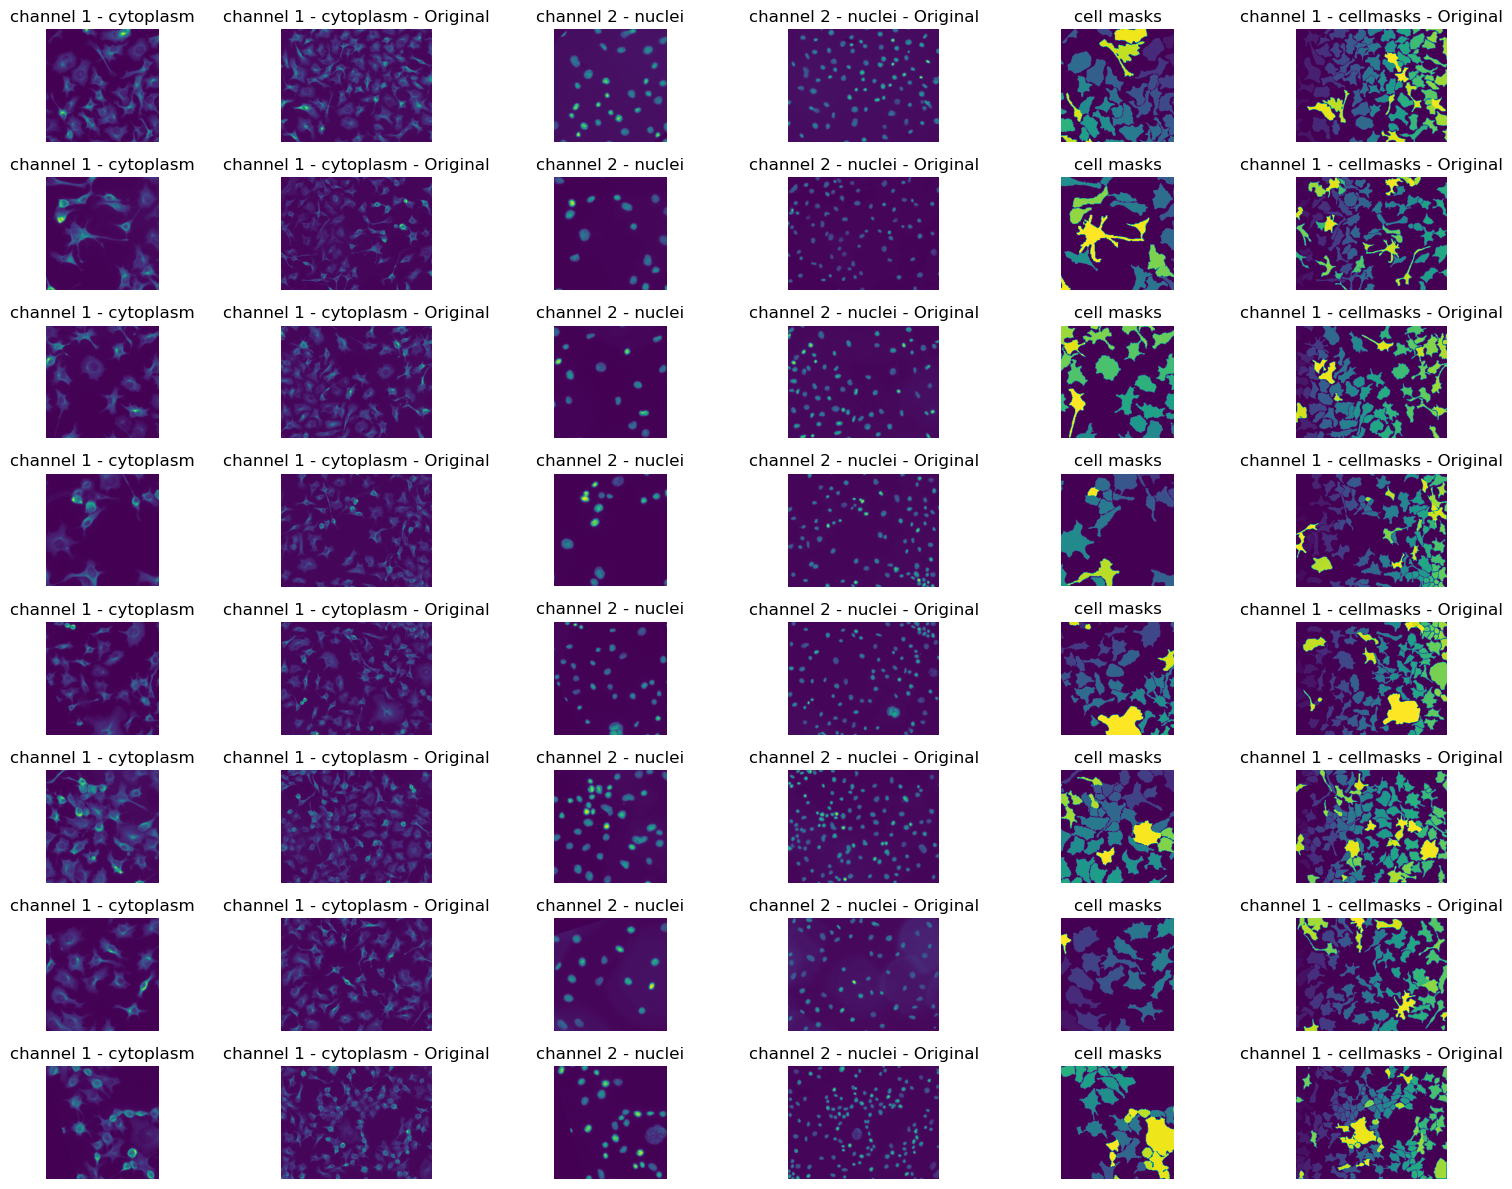

In [15]:
def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True):
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1], xy[0]),
                                  flags=cv2.INTER_NEAREST)

  return imgi, lbl, scale


img_batch, lbl_batch, scale = random_rotate_and_resize(imgs_train[:8],
                                                       masks_train[:8])

plt.figure(figsize=(16, 12))
for j in range(8):
  plt.subplot(8, 6, 6*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('channel 1 - cytoplasm')
  plt.axis('off')

  plt.subplot(8, 6, 6*j + 2)
  plt.imshow(imgs_train[j, 0])
  plt.title('channel 1 - cytoplasm - Original')
  plt.axis('off')

  plt.subplot(8, 6, 6*j + 3)
  plt.imshow(img_batch[j, 1])
  plt.title('channel 2 - nuclei')
  plt.axis('off')

  plt.subplot(8, 6, 6*j + 4)
  plt.imshow(imgs_train[j, 1])
  plt.title('channel 2 - nuclei - Original')
  plt.axis('off')

  plt.subplot(8, 6, 6*j + 5)
  plt.imshow(lbl_batch[j, 0])
  plt.title('cell masks')
  plt.axis('off')
  
  plt.subplot(8, 6, 6*j + 6)
  plt.imshow(masks_train[j])
  plt.title('channel 1 - cellmasks - Original')
  plt.axis('off')


plt.tight_layout()
plt.show()

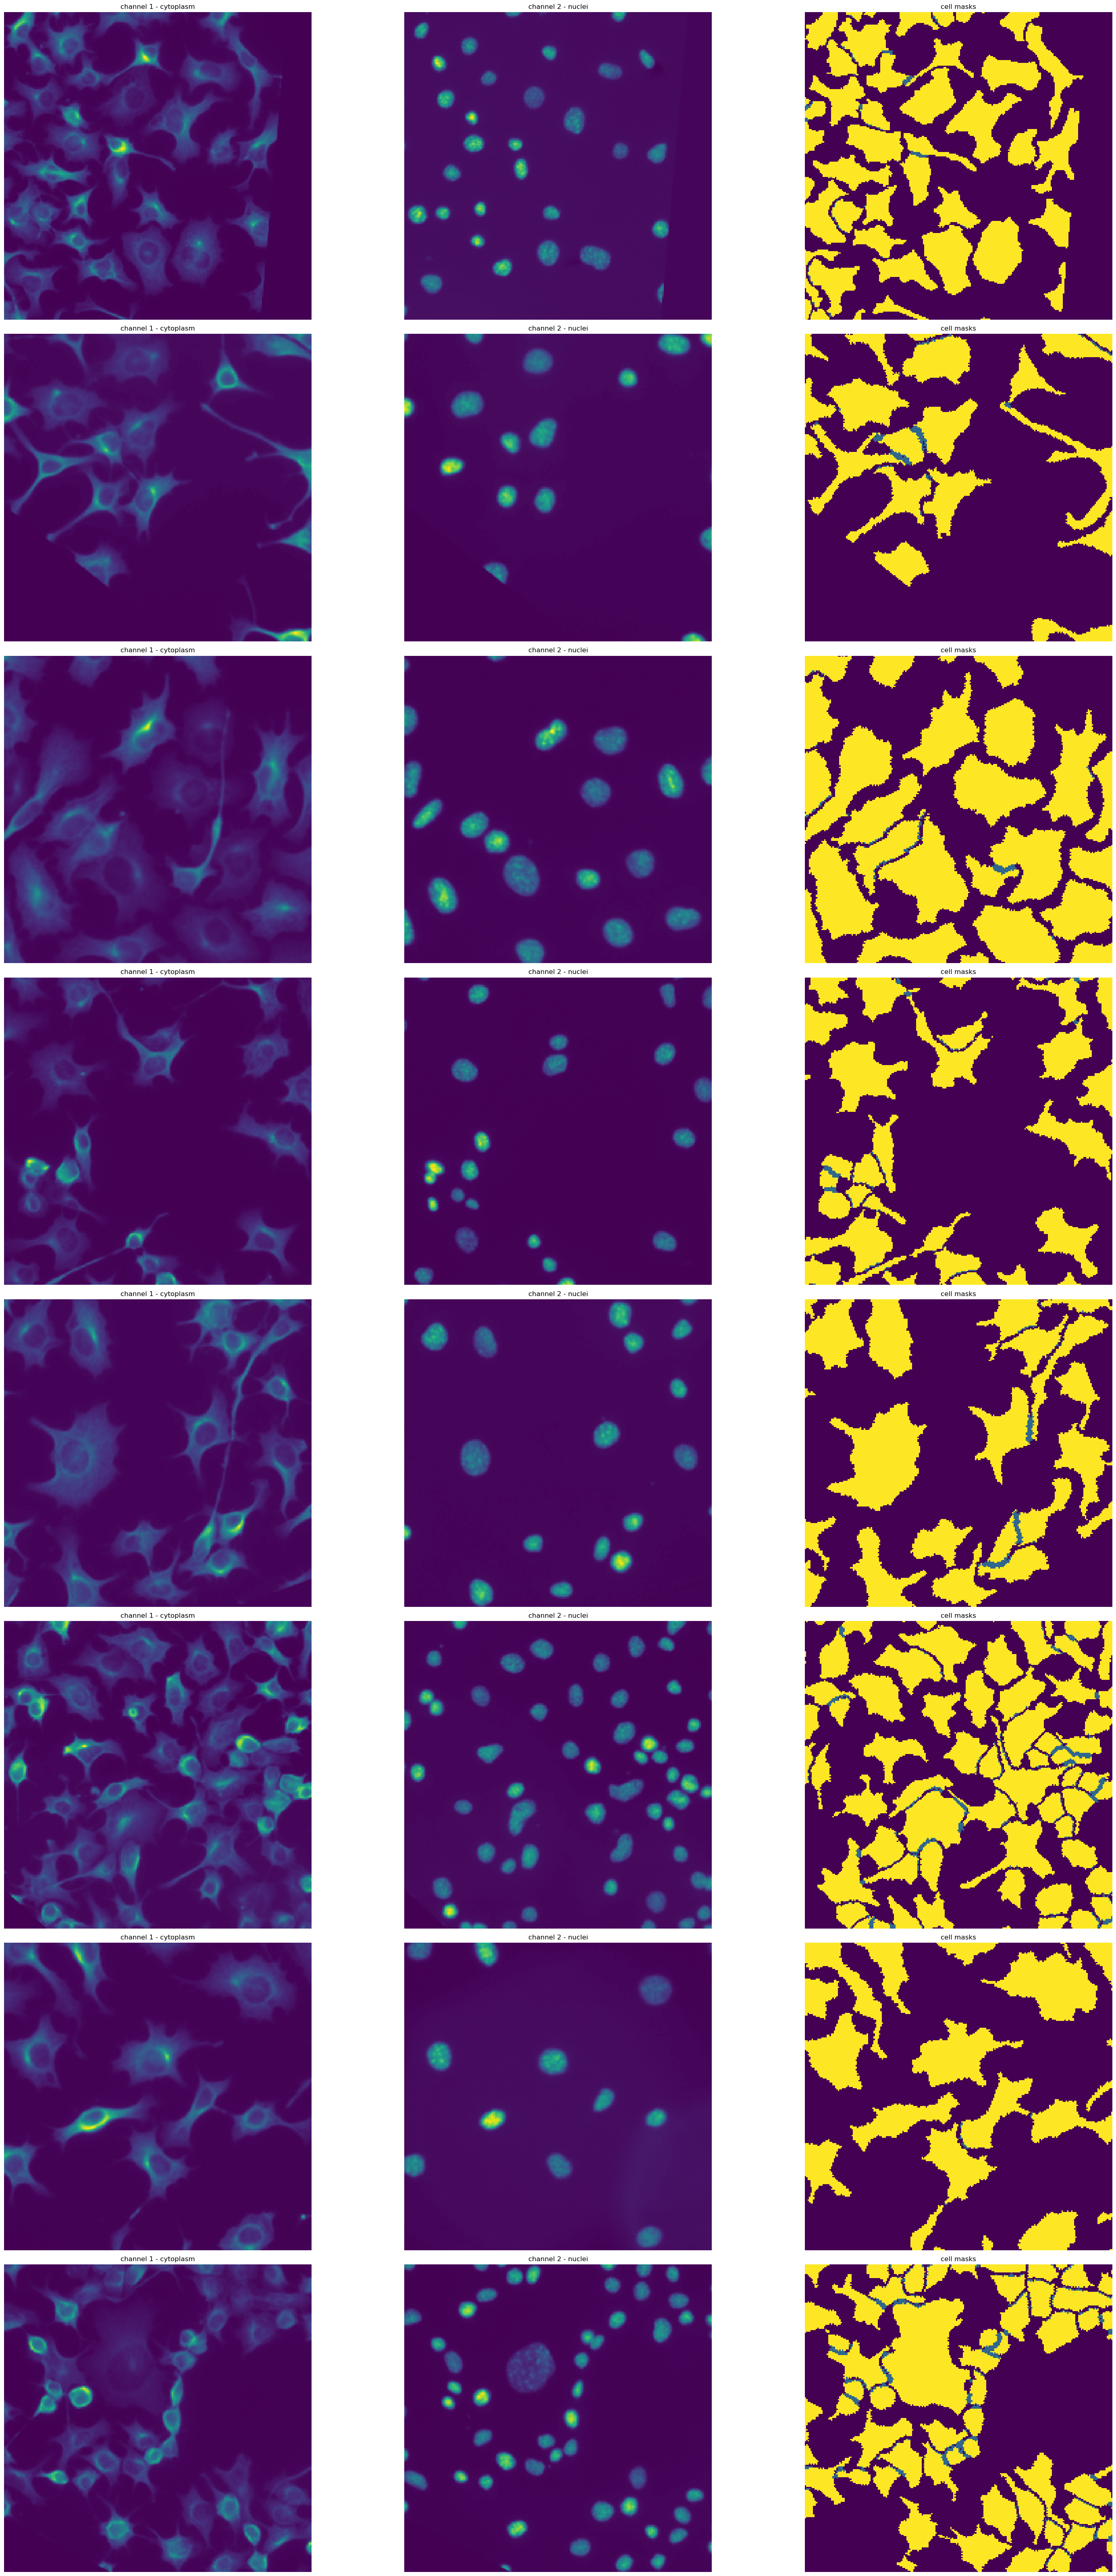

In [16]:
img_batch, lbl_batch, scale = random_rotate_and_resize(imgs_train[:8],
                                                       w_labels_train[:8])

plt.figure(figsize=(32, 64))
for j in range(8):
  plt.subplot(8, 3, 3*j + 1)
  plt.imshow(img_batch[j, 0])
  plt.title('channel 1 - cytoplasm')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 2)
  plt.imshow(img_batch[j, 1])
  plt.title('channel 2 - nuclei')
  plt.axis('off')

  plt.subplot(8, 3, 3*j + 3)
  plt.imshow(lbl_batch[j, 1])
  plt.title('cell masks')
  plt.axis('off')
plt.tight_layout()
plt.show()

# Model architecture (u-net)

A u-net is commonly used for biological image segmentation because its shape allows for local and global features to be combined to create highly-precise segmentations.

A u-net is shaped like an autoencoder, it has:
1. a standard convolutional network with downsampling, like one used for imagenet
2. upsampling layers that ultimately return an image at the same size as the input image
In addition to these downsampling and upsampling blocks, it has skip connections from the downsampling blocks TO the upsampling blocks, which allows it to propagate more precise local information to the later layers.

adapted from [cellpose/resnet_torch.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/resnet_torch.py).


In [17]:
def convbatchrelu(in_channels, out_channels, sz, threshold):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      nn.Dropout(threshold)
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, threshold):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size,
                                           threshold))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size,
                                           threshold))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      if n != len(nbase) - 2:
          self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size,
                                    n*1.5/10))   # Here we define the probability of the Drop out/ n*1.5/10
      else:
          self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size,
                                    n*1.5/10))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
        # xd.append(self.down[n-1](y))
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels + out_channels,
                                                 out_channels,
                                                 kernel_size,
                                                 0))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size,
                                                 0))

  def forward(self, x, y):
    x = self.conv[0](torch.cat((x,y),1))
    x = self.conv[1](x)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      # if n > 0:
      x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 2 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    # nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

### Define the network

In [18]:
kernel_size = 3
nbase = [2, 32, 64, 128, 256, 512, 1024]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

Unet(
  (downsample): downsample(
    (down): Sequential(
      (conv_down_0): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Dropout(p=0.0, inplace=False)
          )
          (conv_1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (conv_down_1): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### Train the network


In [19]:
w1_labels_train = np.ones_like(w_labels_train)

w1_labels_train[:,0] = (w_labels_train[:,0]*10)+1

In [20]:
# Used to calculate the precision of the model on the given dataset.
### This function uses cell_threshold 
def calc_precision(imgs_test, masks_test):
    IoU_threshold = 0.5
    net.eval()
    ap_tot=[]
    # (depending on GPU capacity you may need to run this in a loop)
    for i in range ( 0, int(imgs_test.shape[0]), 2):

        test_padded, slices = pad_image_ND(imgs_test[i:i+2], 32)
        test_torch = torch.from_numpy(test_padded).to(device)
        out = net(test_torch)
    # compute CELL / NOT CELL probability
        labels = out[slices].detach().cpu().numpy()

    # create masks from probabilities
        masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

    # (note this function expects multiple masks)
        iou_threshold = np.array([IoU_threshold], "float64")
        ap = average_precision(masks_test[i:i+2], masks, threshold=iou_threshold)[0]
        ap_tot.append(ap)
        return np.array(ap_tot).mean()
    # precision_per_iter.append(np.array(ap_tot).mean(axis=1).mean(axis=0))
    net.train()

In [ ]:
from numpy.core.numeric import ones_like
from datetime import datetime

# parameters related to training the network
batch_size = 8 

n_epochs = 1000 
learning_rate = 0.1 
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 
n_epochs_per_save = 25 
val_frac = 0.1 # what fraction of data to use for validation

# where to save the network
# make sure to clean these out every now and then, as you will run out of space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

# split into train and validation datasets
n_val = int(len(imgs_train) * val_frac)
n_train = len(imgs_train) - n_val
np.random.seed(0)
iperm = np.random.permutation(len(imgs_train))   #shuffled indices
train_data, val_data = imgs_train[iperm[:n_train]], imgs_train[iperm[n_train:]]
train_labels, val_labels = w_labels_train[iperm[:n_train]], w_labels_train[iperm[n_train:]]
train_masks, val_masks = masks_train[iperm[:n_train]], masks_train[iperm[n_train:]]


# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)
# set learning rate schedule
LR = np.linspace(0, learning_rate, 10)
if n_epochs > 250:
    LR = np.append(LR, learning_rate*np.ones(n_epochs-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, learning_rate * np.ones(max(0, n_epochs - 10)))


criterion = nn.CrossEntropyLoss(reduction='none')


# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

val_losses = np.zeros(n_epochs)
val_losses[:] = np.nan


# when we last saved the network
saveepoch = None
precision_iter_test=[]
precision_iter_train=[]
# when we last saved the network

saveepoch = None

cell_threshold = 0.023567838594317436
# loop through entire training data set nepochs times
for epoch in range(n_epochs):
   
  epoch_loss = 0
  epoch_loss_val = 0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img', colour="30D5C8", ) as pbar:
    # loop through each batch in the training data
    # put in train mode (affects batchnorm)
    net.train()
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))
      imgs, lbls, _ = random_rotate_and_resize(train_data[inds], train_labels[inds])

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)

      # compute the loss
      y = net(imgs)
      loss = criterion(y, lbls[:, 1].to(dtype=torch.long))   #labels are float and needed to convert to long for Cross entropy

      loss = ((lbls[:, 0]*10)+1)*loss       #the weighted map values are between 0-1 so we multiply them to 10 to 
                                            #increse the loss for wrong labels between close cells   
                                            #+1 : to not zero out true cell labels

      loss = torch.sum(loss.flatten(start_dim=1), axis=0)
      loss = torch.mean(loss)

      epoch_loss += loss.item()
      epoch_loss = epoch_loss/len(imgs)
      pbar.set_postfix(**{'train_batch_loss': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_ZZZ(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])
    
#     #compute validation loss
#     net.eval()
#     inds_val = np.arange(n_val)
#     imgs_val, lbls_val,_ = random_rotate_and_resize(val_data[inds_val], val_labels[inds_val])     #cause I dont have HAAL to crop validation images to 224*224
#     imgs_val = torch.from_numpy(imgs_val).to(device=device)    
#     lbls_val = torch.from_numpy(lbls_val).to(device=device) 
#     y = net(imgs_val)
#     loss_val = criterion(y, lbls_val[:, 1].to(dtype=torch.long))     
#     loss_val = torch.sum(loss_val.flatten(start_dim=1), axis=0)
#     loss_val = torch.mean(loss_val)

#     epoch_loss_val += loss_val.item()
#     epoch_loss_val = epoch_loss_val/len(imgs_val)

#     epoch_losses[epoch] = epoch_loss
#     val_losses[epoch] = epoch_loss_val
    pbar.set_postfix(**{'train_epoch_loss': epoch_loss , 'val_epoch_loss':epoch_loss_val})  #update('loss (epoch) = %f'%epoch_loss)
  precision_iter_test.append(calc_precision(imgs_test, masks_test))
  precision_iter_train.append(calc_precision(imgs_train, masks_train))  
  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/1000: 100%|██████████████████████████| 73/73 [00:06<00:00, 11.81img/s, train_epoch_loss=0.705, val_epoch_loss=0]



Saving network state at epoch 1


Epoch 26/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.19img/s, train_epoch_loss=0.507, val_epoch_loss=0]



Saving network state at epoch 26


Epoch 51/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.19img/s, train_epoch_loss=0.486, val_epoch_loss=0]



Saving network state at epoch 51


Epoch 76/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.18img/s, train_epoch_loss=0.597, val_epoch_loss=0]



Saving network state at epoch 76


Epoch 101/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.17img/s, train_epoch_loss=0.557, val_epoch_loss=0]



Saving network state at epoch 101


Epoch 126/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.18img/s, train_epoch_loss=0.343, val_epoch_loss=0]



Saving network state at epoch 126


Epoch 151/1000: 100%|████████████████████████| 73/73 [00:06<00:00, 12.14img/s, train_epoch_loss=0.415, val_epoch_loss=0]



Saving network state at epoch 151


Epoch 176/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.17img/s, train_epoch_loss=0.532, val_epoch_loss=0]



Saving network state at epoch 176


Epoch 201/1000: 100%|█████████████████████████| 73/73 [00:06<00:00, 11.20img/s, train_epoch_loss=0.34, val_epoch_loss=0]



Saving network state at epoch 201


Epoch 226/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.19img/s, train_epoch_loss=0.49, val_epoch_loss=0]



Saving network state at epoch 226


Epoch 251/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.19img/s, train_epoch_loss=0.33, val_epoch_loss=0]



Saving network state at epoch 251


Epoch 276/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.20img/s, train_epoch_loss=0.501, val_epoch_loss=0]



Saving network state at epoch 276


Epoch 301/1000: 100%|████████████████████████| 73/73 [00:06<00:00, 12.15img/s, train_epoch_loss=0.698, val_epoch_loss=0]



Saving network state at epoch 301


Epoch 326/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.20img/s, train_epoch_loss=0.373, val_epoch_loss=0]



Saving network state at epoch 326


Epoch 351/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.18img/s, train_epoch_loss=0.527, val_epoch_loss=0]



Saving network state at epoch 351


Epoch 376/1000: 100%|████████████████████████| 73/73 [00:06<00:00, 12.15img/s, train_epoch_loss=0.489, val_epoch_loss=0]



Saving network state at epoch 376


Epoch 401/1000: 100%|████████████████████████| 73/73 [00:06<00:00, 12.13img/s, train_epoch_loss=0.515, val_epoch_loss=0]



Saving network state at epoch 401


Epoch 426/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.19img/s, train_epoch_loss=0.36, val_epoch_loss=0]



Saving network state at epoch 426


Epoch 451/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.17img/s, train_epoch_loss=0.485, val_epoch_loss=0]



Saving network state at epoch 451


Epoch 476/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.34img/s, train_epoch_loss=0.561, val_epoch_loss=0]



Saving network state at epoch 476


Epoch 501/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.34img/s, train_epoch_loss=0.412, val_epoch_loss=0]



Saving network state at epoch 501


Epoch 526/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.21img/s, train_epoch_loss=1.32, val_epoch_loss=0]



Saving network state at epoch 526


Epoch 551/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.35img/s, train_epoch_loss=0.456, val_epoch_loss=0]



Saving network state at epoch 551


Epoch 576/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.35img/s, train_epoch_loss=0.489, val_epoch_loss=0]



Saving network state at epoch 576


Epoch 601/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.35img/s, train_epoch_loss=0.422, val_epoch_loss=0]



Saving network state at epoch 601


Epoch 626/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.35img/s, train_epoch_loss=0.393, val_epoch_loss=0]



Saving network state at epoch 626


Epoch 651/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.36img/s, train_epoch_loss=0.334, val_epoch_loss=0]



Saving network state at epoch 651


Epoch 676/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.33img/s, train_epoch_loss=0.437, val_epoch_loss=0]



Saving network state at epoch 676


Epoch 701/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.30img/s, train_epoch_loss=0.277, val_epoch_loss=0]



Saving network state at epoch 701


Epoch 726/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.33img/s, train_epoch_loss=0.408, val_epoch_loss=0]



Saving network state at epoch 726


Epoch 751/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.33img/s, train_epoch_loss=0.566, val_epoch_loss=0]



Saving network state at epoch 751


Epoch 776/1000: 100%|█████████████████████████| 73/73 [00:05<00:00, 12.35img/s, train_epoch_loss=0.45, val_epoch_loss=0]



Saving network state at epoch 776


Epoch 801/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.26img/s, train_epoch_loss=0.298, val_epoch_loss=0]



Saving network state at epoch 801


Epoch 826/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.30img/s, train_epoch_loss=0.338, val_epoch_loss=0]



Saving network state at epoch 826


Epoch 851/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.36img/s, train_epoch_loss=0.307, val_epoch_loss=0]



Saving network state at epoch 851


Epoch 876/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.34img/s, train_epoch_loss=0.386, val_epoch_loss=0]



Saving network state at epoch 876


Epoch 901/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.24img/s, train_epoch_loss=0.315, val_epoch_loss=0]



Saving network state at epoch 901


Epoch 926/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.34img/s, train_epoch_loss=0.252, val_epoch_loss=0]



Saving network state at epoch 926


Epoch 951/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.36img/s, train_epoch_loss=0.263, val_epoch_loss=0]



Saving network state at epoch 951


Epoch 976/1000: 100%|████████████████████████| 73/73 [00:05<00:00, 12.34img/s, train_epoch_loss=0.261, val_epoch_loss=0]



Saving network state at epoch 976


Epoch 1000/1000: 100%|███████████████████████| 73/73 [00:05<00:00, 12.33img/s, train_epoch_loss=0.309, val_epoch_loss=0]



Saving network state at epoch 1000


This figure is only valid for cell_threshold = -1.7788944244384766


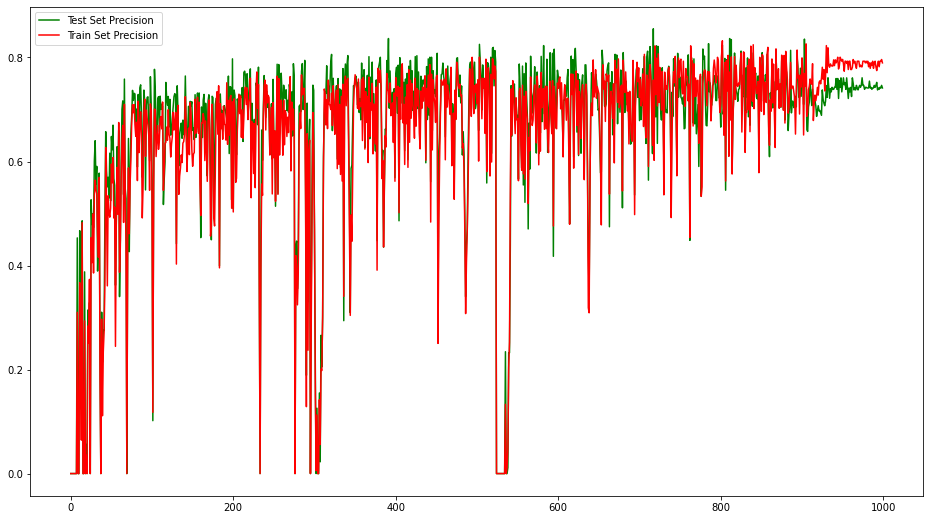

In [ ]:
print(f"This figure is only valid for cell_threshold = {cell_threshold}")
figure, axes = plt.subplots(); 
plt.plot(precision_iter_test, "g", label="Test Set Precision");
plt.plot(precision_iter_train, "r", label="Train Set Precision");
plt.legend();
figure.set_size_inches(16, 9)
# precision_iter_test[-10:]

In [ ]:
# # To save weights, use this cell
# torch.save( net, 'u_weight_3_9_nbase1024__dropout0.pth')
# torch.save( net.state_dict(), 'u_weight_3_9_nbase1024__1000epoch__dropout0.pth')



In [ ]:
# ## To load weights, use this cell
# net1 = torch.load('u_weight_3_9_nbase1024__dropout0.pth')

# net1.load_state_dict(torch.load('u_weight_3_9_nbase1024__1000epoch__dropout0.pth'))
# net1.eval()


Unet(
  (downsample): downsample(
    (down): Sequential(
      (conv_down_0): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv_1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
      )
      (conv_down_1): convdown(
        (conv): Sequential(
          (conv_0): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv_1): Sequent

### Test performance

In [ ]:
# Padding code for test images

def pad_image_ND(img0, div=16, extra=1):
  """ pad image for test-time so that its dimensions are a multiple of 16 (2D or 3D)

  Parameters
  -------------
  img0: ND-array
      image of size [nchan (x Lz) x Ly x Lx]
  div: int (optional, default 16)

  Returns
  --------------
  I: ND-array
      padded image
  slices: tuple, int
      range of pixels in I corresponding to img0
  """
  Lpad = int(div * np.ceil(img0.shape[-2] / div) - img0.shape[-2])
  xpad1 = extra * div//2 + Lpad//2
  xpad2 = extra * div//2 + Lpad - Lpad//2
  Lpad = int(div * np.ceil(img0.shape[-1] / div) - img0.shape[-1])
  ypad1 = extra * div//2 + Lpad//2
  ypad2 = extra * div//2 + Lpad - Lpad//2

  if img0.ndim > 3:
    pads = np.array([[0, 0], [0, 0], [xpad1, xpad2], [ypad1, ypad2]])
  else:
    pads = np.array([[0, 0], [xpad1, xpad2], [ypad1, ypad2]])

  I = np.pad(img0, pads, mode='constant')

  Ly, Lx = img0.shape[-2:]
  ysub = np.arange(xpad1, xpad1 + Ly)
  xsub = np.arange(ypad1, ypad1 + Lx)
  slc = [slice(0, img0.shape[n] + 1) for n in range(img0.ndim)]
  slc[-3] = slice(0, img0.shape[-3] + 1)
  slc[-2] = slice(ysub[0], ysub[-1] + 1)
  slc[-1] = slice(xsub[0], xsub[-1] + 1)
  slc = tuple(slc)

  return I, slc

In [ ]:
net.eval()
irand = 8
test_padded, slices = pad_image_ND(imgs_test[irand:irand+1], 32)
test_torch = torch.from_numpy(test_padded).cuda()
out = net(test_torch)


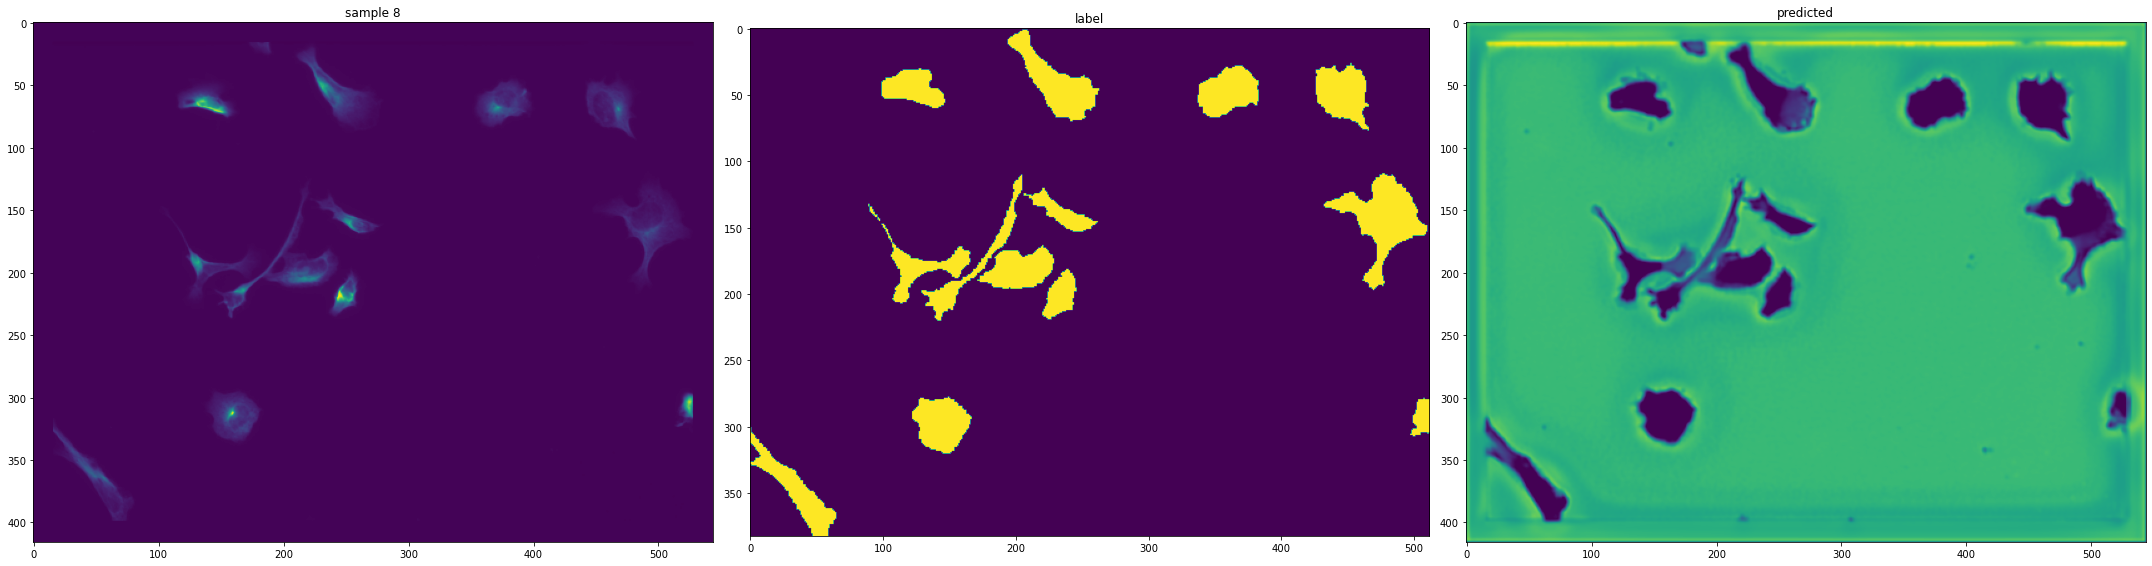

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(1, 3, 1)
plt.imshow(np.array(test_torch[0,0].cpu().detach()))
plt.title('sample 8')

plt.subplot(1, 3, 2)
plt.imshow(w_labels_test[8,1])
plt.title('label')

plt.subplot(1, 3, 3)
plt.imshow(np.array((out[0,0]-out[0,1]).cpu().detach()))
plt.title('predicted')
plt.tight_layout()
plt.show()

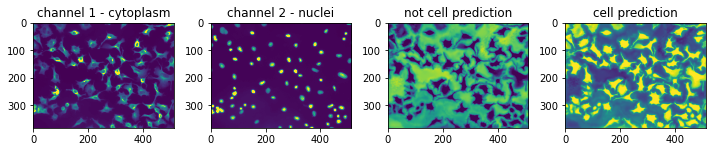

In [ ]:
# compute results on test images
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))

net.eval()
img_padded, slices = pad_image_ND(imgs_test[0], 32)
img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
out = net(img_torch)
labels = out[0][slices].detach().cpu()

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(imgs_test[0][0], vmin=0, vmax=1)
plt.title('channel 1 - cytoplasm')

plt.subplot(1, 4, 2)
plt.imshow(imgs_test[0][1], vmin=0, vmax=1)
plt.title('channel 2 - nuclei')

plt.subplot(1, 4, 3)
plt.imshow(labels[0])
plt.title('not cell prediction')

plt.subplot(1, 4, 4)
plt.imshow(labels[1])
plt.title('cell prediction')
plt.tight_layout()
plt.show()

### Setting threshold for finding cells

We have found areas of "not cell" and "cell". To create an instance segmentation we need to assign each pixel in a cell to a specific cell rather than a general class. To do this, we will need to find a threshold that produces the best segmentations on our validation set. How do we define a good segmentation? We can use a measure called intersection-over-union (IoU) and call a cell a good cell if it overlaps with a ground-truth cell with an IoU greater than some value. We have taken code from [cellpose/metrics.py] to do this.

In [ ]:
def fill_holes_and_remove_small_masks(masks, min_size=15):
  """ fill holes in masks (2D/3D) and discard masks smaller than min_size (2D)

  fill holes in each mask using scipy.ndimage.morphology.binary_fill_holes

  Parameters
  ----------------
  masks: int, 2D or 3D array
      labelled masks, 0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  min_size: int (optional, default 15)
      minimum number of pixels per mask, can turn off with -1

  Returns
  ---------------
  masks: int, 2D or 3D array
      masks with holes filled and masks smaller than min_size removed,
      0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  """
  slices = find_objects(masks)
  j = 0
  for i,slc in enumerate(slices):
    if slc is not None:
      msk = masks[slc] == (i + 1)
      npix = msk.sum()
      if min_size > 0 and npix < min_size:
        masks[slc][msk] = 0
      else:
        if msk.ndim==3:
          for k in range(msk.shape[0]):
            msk[k] = binary_fill_holes(msk[k])
        else:
          msk = binary_fill_holes(msk)
        masks[slc][msk] = (j + 1)
        j += 1

  return masks


# @markdown `average_precision` function
def average_precision(masks_true, masks_pred, threshold=[0.5, 0.75, 0.9]):
  """ average precision estimation: AP = TP / (TP + FP + FN)

  This function is based heavily on the *fast* stardist matching functions
  (https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py)

  Parameters
  ------------
  masks_true: list of ND-arrays (int)
      where 0=NO masks; 1,2... are mask labels
  masks_pred: list of ND-arrays (int)
      ND-array (int) where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  ap: array [len(masks_true) x len(threshold)]
      average precision at thresholds
  tp: array [len(masks_true) x len(threshold)]
      number of true positives at thresholds
  fp: array [len(masks_true) x len(threshold)]
      number of false positives at thresholds
  fn: array [len(masks_true) x len(threshold)]
      number of false negatives at thresholds
  """
  if not isinstance(threshold, list) and not isinstance(threshold, np.ndarray):
    threshold = [threshold]
  ap  = np.zeros((len(masks_true), len(threshold)), np.float32)
  tp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fn  = np.zeros((len(masks_true), len(threshold)), np.float32)
  n_true = np.array(list(map(np.max, masks_true)))
  n_pred = np.array(list(map(np.max, masks_pred)))
  for n in range(len(masks_true)):
    #_,mt = np.reshape(np.unique(masks_true[n], return_index=True), masks_pred[n].shape)
    if n_pred[n] > 0:
      iou = _intersection_over_union(masks_true[n], masks_pred[n])[1:, 1:]
      for k,th in enumerate(threshold):
        tp[n,k] = _true_positive(iou, th)
    fp[n] = n_pred[n] - tp[n]
    fn[n] = n_true[n] - tp[n]
    ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])

  return ap, tp, fp, fn


@jit(nopython=True)
def _label_overlap(x, y):
  """ fast function to get pixel overlaps between masks in x and y

  Parameters
  ------------
  x: ND-array, int
      where 0=NO masks; 1,2... are mask labels
  y: ND-array, int
      where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  overlap: ND-array, int
      matrix of pixel overlaps of size [x.max()+1, y.max()+1]
  """
  x = x.ravel()
  y = y.ravel()
  overlap = np.zeros((1 + x.max(), 1 + y.max()), dtype=np.uint)
  for i in range(len(x)):
    overlap[x[i], y[i]] += 1

  return overlap


def _intersection_over_union(masks_true, masks_pred):
  """ intersection over union of all mask pairs

  Parameters
  ------------
  masks_true: ND-array, int
      ground truth masks, where 0=NO masks; 1,2... are mask labels
  masks_pred: ND-array, int
      predicted masks, where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  iou: ND-array, float
      matrix of IOU pairs of size [x.max()+1, y.max()+1]
  """
  overlap = _label_overlap(masks_true, masks_pred)
  n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
  n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
  iou[np.isnan(iou)] = 0.0

  return iou


def _true_positive(iou, th):
  """ true positive at threshold th

  Parameters
  ------------
  iou: float, ND-array
      array of IOU pairs
  th: float
      threshold on IOU for positive label

  Returns
  ------------
  tp: float
      number of true positives at threshold
  """
  n_min = min(iou.shape[0], iou.shape[1])
  costs = -(iou >= th).astype(float) - iou / (2 * n_min)
  true_ind, pred_ind = linear_sum_assignment(costs)
  match_ok = iou[true_ind, pred_ind] >= th
  tp = match_ok.sum()

  return tp

In [ ]:
def get_masks_unet(output, cell_threshold=0, min_size=30):
  """ create masks using NOT CELL probability and CELL probability

  min_size: minimum number of pixels in the masks
  """

  cells = (output[1] - output[0]) > cell_threshold
  selem = generate_binary_structure(cells.ndim, connectivity=1)
  masks, nlabels = label(cells, selem)
  shape0 = masks.shape
  _,masks = np.unique(masks, return_inverse=True)
  masks = np.reshape(masks, shape0)
  # fill holes and remove small masks
  masks = fill_holes_and_remove_small_masks(masks, min_size=min_size)

  return masks.astype(np.uint16)


For our trained model, The maximum Precision occurs using cell_threshold = -1.7788944244384766
And the maximum precision is: 82.30693936347961%


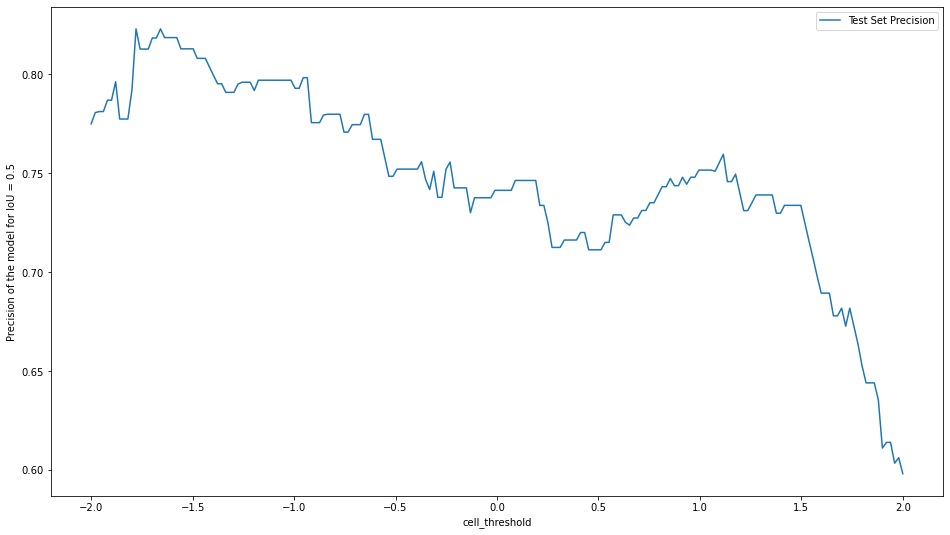

In [ ]:
map_cell_threshold = np.linspace(-2, 2, num=200, endpoint=True, dtype="float32")
y_axis_ct = []
# tmp = cell_threshold
for index, i in enumerate(map_cell_threshold):
    cell_threshold = i
    y_axis_ct.append(calc_precision( imgs_test, masks_test))
    pass
# cell_threshold = tmp

figure, axes = plt.subplots()
plt.plot( map_cell_threshold, y_axis_ct, label="Test Set Precision");
plt.legend();
figure.set_size_inches(16, 9);
plt.xlabel("cell_threshold");
plt.ylabel("Precision of the model for IoU = 0.5")
max_index = np.argmax(y_axis_ct)
best_threshold = map_cell_threshold[np.argmax(y_axis_ct)]
print(f"""For our trained model, The maximum Precision occurs using cell_threshold = {best_threshold}
And the maximum precision is: {y_axis_ct[max_index] * 100}%""")

In [ ]:
cell_threshold = best_threshold

[0.7977436  0.737267   0.67540705 0.5275191  0.23328754]


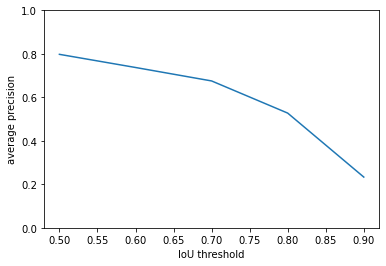

In [ ]:
net.eval()
ap_tot=[]
# (depending on GPU capacity you may need to run this in a loop)
for i in range ( 0, int(imgs_test.shape[0]), 2):
    
    test_padded, slices = pad_image_ND(imgs_test[i:i+2], 32)
    test_torch = torch.from_numpy(test_padded).to(device)
    out = net(test_torch)
# compute CELL / NOT CELL probability
    labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
    masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# (note this function expects multiple masks)
    iou_threshold = np.arange(0.5, 1, 0.1)
    ap = average_precision(masks_test[i:i+2], masks, threshold=iou_threshold)[0]
    ap_tot.append(ap)

# plot results
print(np.array(ap_tot).mean(axis=1).mean(axis=0)) # why is it differrent?
plt.plot(iou_threshold, np.array(ap_tot).mean(0).mean(0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()

# Comparing the Results

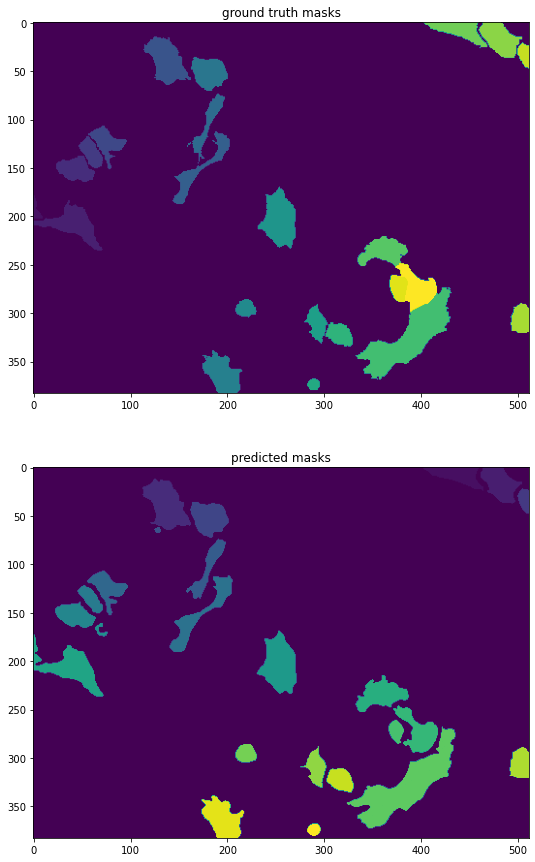

In [ ]:
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
plt.imshow(masks_test[i+1])
plt.title('ground truth masks')
plt.subplot(2, 1, 2)
plt.imshow(masks[1])
plt.title('predicted masks')
plt.show()

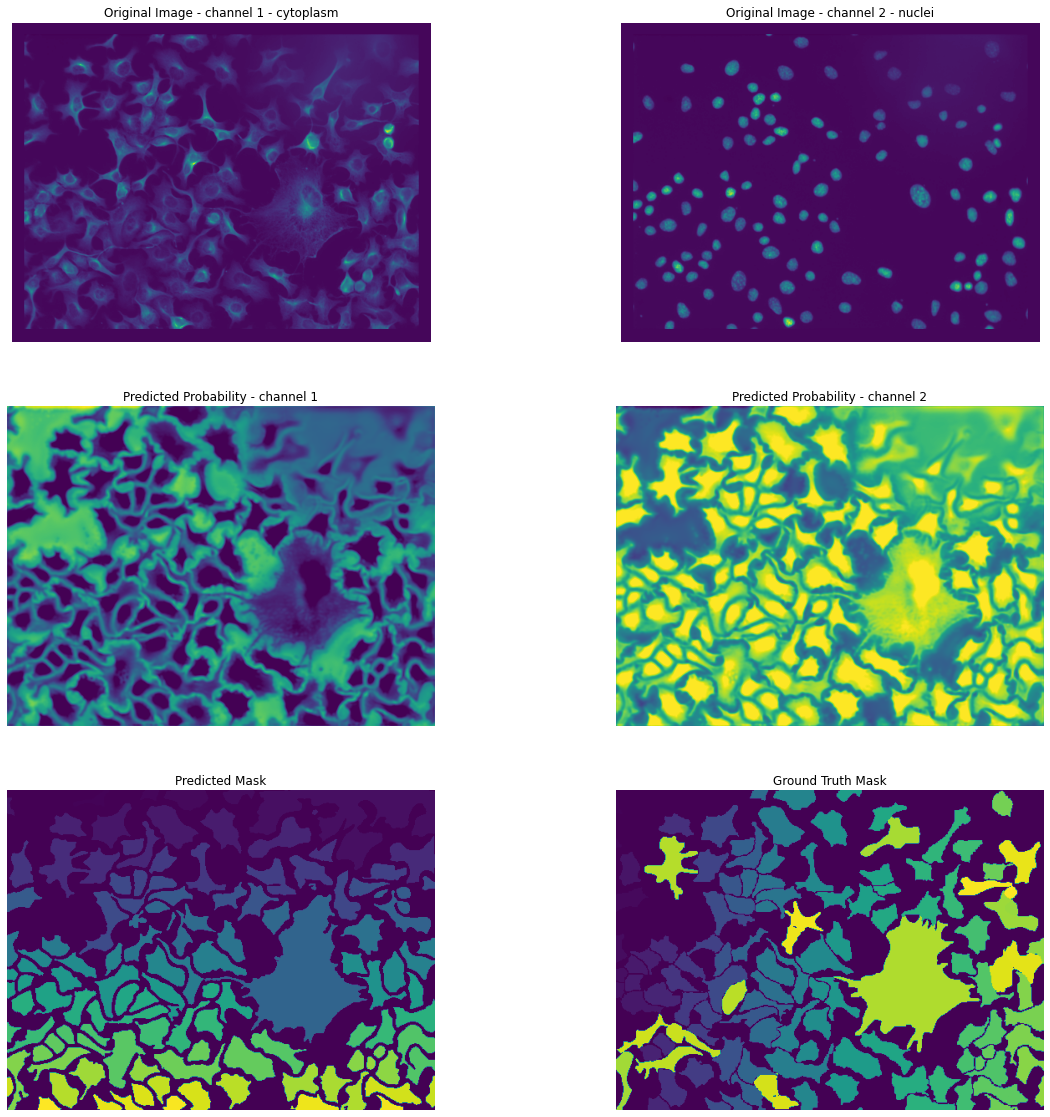

In [ ]:
cell_threshold = best_threshold
# cell_threshold = -1.5

# compute results on test images
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))
irand = np.random.randint(len(imgs_test)-1)
irand = 12
test_padded, slices = pad_image_ND(imgs_train[irand:irand+1], 32)
test_torch = torch.from_numpy(test_padded).to(device)
out = net(test_torch)
# compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]



# Plotting the result
figure, axes = plt.subplots()

plt.subplot(3, 2, 1)
plt.imshow(test_padded[0][0])
plt.title('Original Image - channel 1 - cytoplasm')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(test_padded[0][1])
plt.title('Original Image - channel 2 - nuclei')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(labels[0][0])
plt.title('Predicted Probability - channel 1')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(labels[0][1])
plt.title('Predicted Probability - channel 2')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(masks[0])
plt.title('Predicted Mask')
plt.axis('off')
figure.set_size_inches(20,20)

plt.subplot(3, 2, 6)
plt.imshow(masks_train[irand])
plt.title('Ground Truth Mask')
plt.axis('off')
figure.set_size_inches(20,20)
